# A review of the Fire Weather Index's use in predicting forest fires in a mediterranean climate

Table of contents
- [1.Introduction](#section1)
- [2.Data Description and Exploratory Analysis](#section2)
  - [2.1 Our dataset](#subsection2.1)
  - [2.2 The use of the date in our models](#subsection2.2)
  - [2.3 Seperating the target value from the features](#subsection2.3)
  - [2.4 Standardisation or normalisation?](#subsection2.4)
  - [2.5 Our three data frames](#subsection2.5)
  - [2.6 Reducing our dimensionality using PCA](#subsection2.6)
- [3.Building our models](#section3)
  - [3.1 Decision tree](#subsection3.1)
  - [3.2 Neural network](#subsection3.2)
- [4.Discussion of results](#section4)
  - [4.1 Confusion matrices](#subsection4.1)
  - [4.2 Use the Fire Weather Index or exclude it?](#subsection4.2)
  - [4.3 Neural network or decision tree?](#subsection4.3)
- [5.Conclusion](#section5)
  - [5.1 Limitations](#subsection5.1)
  - [5.2 Our reccomendation](#subsection5.2)
- [6.References](#section6)

## 1. Introduction <a name="section1"></a>

<ins>**Introduction to the FWI**</ins>

The Fire Weather Index(FWI) is a system using a multitude of features to estimate the risk of wildfire in a given region. Initially computed and issued as a model in the 1970s by researchers in the canadian forestry research, it had its primary utility with a pine fuel type commonly found in canadian forests, however it was also found to be useful as a general model for predicting the risk of forest fire[1].



<ins>**How the FWI is calculated**</ins>

The Fire weather index is derived from a series of formulas including weather observations which produce a series of "fuel moisture codes". The fuel moisture codes then contribute to formulas that calculate fire behaviour indices which ultimatley calculate the risk of fire in the region represented by the fire weather index[2].

<img src = "https://cwfis.cfs.nrcan.gc.ca/images/fwi_structure.gif">

FIGURE 1: A representation of how the fire weather index is calculated, [figure taken from the government of canada website](https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi)

<ins>**Use of the FWI in the mediterranean climate**</ins>

There is precedent for use of the FWI in a mediterranean climate, for example in 2018 a number of researchers assessed and applied the model to classify the risk of spontaneous wildfire in greece. They found considerable challenges in adapting the model for the unique climactic conditions of the mediterranean[3]. Using data collected in 2012 from Algeria we will attempt to generate two distinct models to predict the risk of forest fire and determine if the use of the FWI signficantly improves our models ability to correctly classify the conditions for a forest fire or if the introduction of this information produces a negligible/detrimental effect, needlessly increasing it's complexity/overfitting our model.

## 2.Data Description and Exploratory Analysis<a name="section2"></a>

###<ins>2.1 Our dataset</ins> <a name="subsection2.1"></a>

 The data in our report originates from two distinct regions in algeria and has 243 samples consisting of 12 features collected on site including general measurements of the environment (wind speed, humidity, temperature etc.) as well as key measurements used in the FWI (such as Fine Fuel Moisture Code, Buildup Index etc.). Also included is a feature reporting whether wildfires we're present in the regions which we will use as our target feature to train our models on to predict.

In [85]:
#imported libraries for use in our report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import sklearn.model_selection as skmodel
import sklearn.tree as sktree
import sklearn.metrics as skmetrics
import sklearn.decomposition as decompose
import sklearn.neural_network as network
import seaborn as sns

In [86]:
#read in data frame
columns = ['Day', 'Month', 'Temperature(C)', 'Relative Humidity', 'Wind Speed(km/h)', 'Daily Rainfall(mm)', 'Fine Fuel Moisture Code', 'Duff Moisture Code', 'Drought Code', 'Initial Spread Index', 'Buildup Index', 'Fire Weather Index', 'Fire?']
data_frame = pd.read_csv("ForestFire.csv", names=columns)
#Change "fire?" to int for better use as a classification value in our models
fire_object_array = data_frame['Fire?']
fire_int_array = []
for fire_label in fire_object_array:
  if(fire_label == 'fire'):
    fire_int_array.append(1)
  else:
    fire_int_array.append(0)
data_frame['Fire?'] = fire_int_array
#Preview data
data_frame.head(10)

,Day,Month,Temperature(C),Relative Humidity,Wind Speed(km/h),Daily Rainfall(mm),Fine Fuel Moisture Code,Duff Moisture Code,Drought Code,Initial Spread Index,Buildup Index,Fire Weather Index,Fire?
0,1,6,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0
1,2,6,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0
2,3,6,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0
3,4,6,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0
4,5,6,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0
5,6,6,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,1
6,7,6,33,54,13,0.0,88.2,9.9,30.5,6.4,10.9,7.2,1
7,8,6,30,73,15,0.0,86.6,12.1,38.3,5.6,13.5,7.1,1
8,9,6,25,88,13,0.2,52.9,7.9,38.8,0.4,10.5,0.3,0
9,10,6,28,79,12,0.0,73.2,9.5,46.3,1.3,12.6,0.9,0


TABLE 1: The first 10 samples of our entire dataset visualised

As we can see from table 1 and figure 1 there are features such as the temperature, relative humidity, windspeed etc. which already contribute to features related to the FWI. The goal of our models are to determine if including features from the FWI is any better than simply using the collected fire weather observation features.

###<ins>2.2 The use of the date in our models</ins> <a name="subsection2.2"></a>

Our data was collected in samples from the 1st of June to the 30th of September.The day and the month a fire may occur on isnt a useful metric for our models by itself however if we combine the two into a feature which essentially represents the "progression of summer" we can see some significance.

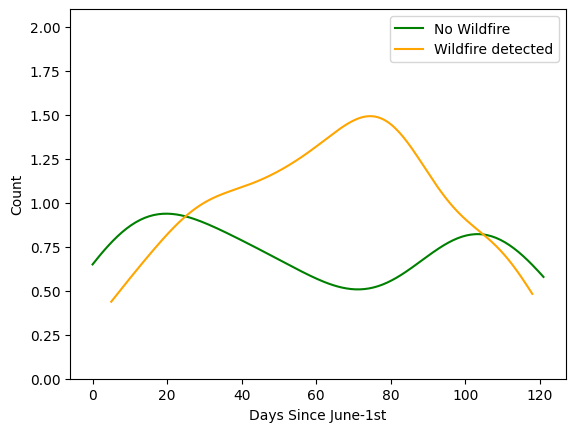

In [87]:
#Create "Days since june 1st" feature
days_since_june_1st_column = []
for index, row in data_frame.iterrows():
  month_day_value = (row['Day'] - 1)
  if(row['Month'] == 7.0):
    month_day_value += 30
  elif(row['Month'] == 8.0):
    month_day_value += 61
  elif(row['Month'] == 9.0):
    month_day_value += 92
  days_since_june_1st_column.append(month_day_value)
data_frame.insert(loc=0, column='Days Since June-1st', value=days_since_june_1st_column)

#plot distributions of days where there are and aren't wildfires
fig, axs = plt.subplots(1, 1)
sns.histplot(data_frame['Days Since June-1st'][data_frame['Fire?'] == 0], ax=axs, bins=122, color='green', label='No Wildfire', kde=True)
axs.containers[0].remove()#remove bars
axs.plot([], [], color='green', label='No Wildfire')#empty frame to fit legend
sns.histplot(data_frame['Days Since June-1st'][data_frame['Fire?'] == 1], ax=axs, bins=122, color='orange', label='Wildfire detected', kde=True)
axs.containers[0].remove()#remove bars
axs.plot([], [], color='orange', label='Wildfire detected')#empty frame to fit legend
axs.legend()

plt.show()

FIGURE 2: A kernel density estimation plot representing the smooth estimate of number of wildfires on all days from june 1st to september 30th.

As summer progresses the likelyhood of a wildfire increases around the 70th day and then decreases around the 80th day, reports of no wildfires being detected peak in two distinct places. This peak in wildfire and bimodal distribution for no wildfire would be much more useful for our models, therefore we will retain this feature while dropping the "Day" and "Month" column from our data frame.

The source of this effect is likely due to climatic conditions of summer which are already represented in other parts of our dataframe, however there may be conditions past concepts like temperature, humidity, wind speed etc. that weren't collected elsewhere and therefore the date can act as a value for these unnoticed factors that aren't otherwise features in our dataset

In [88]:
#drop day and month
data_frame = data_frame.drop(['Day', 'Month'], axis=1)

###2.3 <ins>Seperating the target value from the features</ins><a name="subsection2.3"></a>

In order to do further preprocessing on our dataset we will now split the dataset into a frame containing just the target value and one containing the remaining features.

In [89]:
#make label_frame and feature frame
label_frame = data_frame['Fire?']
feature_frame = data_frame.drop(['Fire?'], axis=1)

###<ins>2.4 Standardisation or normalisation?</ins><a name="subsection2.4"></a>

Because all features in our dataset have a set range we will be able to normalise the features of our data set to prevent any one feature skewing our model or visualisations massively.

In [90]:
#make normalised frame
def normalise_column(column):
  return (column - column.min()) / (column.max() - column.min())

normalised_feature_frame = feature_frame.apply(normalise_column)
normalised_feature_frame.head(10)

,Days Since June-1st,Temperature(C),Relative Humidity,Wind Speed(km/h),Daily Rainfall(mm),Fine Fuel Moisture Code,Duff Moisture Code,Drought Code,Initial Spread Index,Buildup Index,Fire Weather Index
0,0.000000,0.35,0.521739,0.521739,0.000000,0.550445,0.041411,0.003279,0.068421,0.034380,0.016077
1,0.008264,0.35,0.579710,0.304348,0.077381,0.531157,0.052147,0.003279,0.052632,0.041854,0.012862
2,0.016529,0.20,0.884058,0.695652,0.779762,0.274481,0.027607,0.000937,0.015789,0.023916,0.003215
3,0.024793,0.15,0.985507,0.304348,0.148810,0.000000,0.009202,0.000000,0.000000,0.008969,0.000000
4,0.033058,0.25,0.811594,0.434783,0.000000,0.537092,0.035276,0.034192,0.063158,0.041854,0.016077
5,0.041322,0.45,0.666667,0.347826,0.000000,0.801187,0.078221,0.071663,0.163158,0.088191,0.080386
6,0.049587,0.55,0.478261,0.304348,0.000000,0.884273,0.141104,0.110539,0.336842,0.146487,0.231511
7,0.057851,0.40,0.753623,0.391304,0.000000,0.860534,0.174847,0.147073,0.294737,0.185351,0.228296
8,0.066116,0.15,0.971014,0.304348,0.011905,0.360534,0.110429,0.149415,0.021053,0.140508,0.009646
9,0.074380,0.30,0.840580,0.260870,0.000000,0.661721,0.134969,0.184543,0.068421,0.171898,0.028939


TABLE 2: The first 10 features of our normalised feature frame

###<ins>2.5 Our three dataframes</ins><a name="subsection2.5"></a>

We will now generate a secondary feature frame with the features containing the FWI excluded. So in total we will have 3 unique data frames from our dataset:
1. A feature frame containing all features of the dataset
2. A feature frame excluding all metrics of the fire weather index
3. A label frame containing our target value


In [91]:
#generate the two normalised feature frames
fire_weather_included_frame = normalised_feature_frame
fire_weather_excluded_frame = fire_weather_included_frame.drop(['Fire Weather Index', 'Buildup Index', 'Initial Spread Index', 'Drought Code', 'Duff Moisture Code', 'Fine Fuel Moisture Code'], axis=1)

In [92]:
fire_weather_included_frame.head(5)

,Days Since June-1st,Temperature(C),Relative Humidity,Wind Speed(km/h),Daily Rainfall(mm),Fine Fuel Moisture Code,Duff Moisture Code,Drought Code,Initial Spread Index,Buildup Index,Fire Weather Index
0,0.000000,0.35,0.521739,0.521739,0.000000,0.550445,0.041411,0.003279,0.068421,0.034380,0.016077
1,0.008264,0.35,0.579710,0.304348,0.077381,0.531157,0.052147,0.003279,0.052632,0.041854,0.012862
2,0.016529,0.20,0.884058,0.695652,0.779762,0.274481,0.027607,0.000937,0.015789,0.023916,0.003215
3,0.024793,0.15,0.985507,0.304348,0.148810,0.000000,0.009202,0.000000,0.000000,0.008969,0.000000
4,0.033058,0.25,0.811594,0.434783,0.000000,0.537092,0.035276,0.034192,0.063158,0.041854,0.016077


TABLE 3: The first 5 samples of our normalised dataset with FWI features included

In [93]:
fire_weather_excluded_frame.head(5)

,Days Since June-1st,Temperature(C),Relative Humidity,Wind Speed(km/h),Daily Rainfall(mm)
0,0.000000,0.35,0.521739,0.521739,0.000000
1,0.008264,0.35,0.579710,0.304348,0.077381
2,0.016529,0.20,0.884058,0.695652,0.779762
3,0.024793,0.15,0.985507,0.304348,0.148810
4,0.033058,0.25,0.811594,0.434783,0.000000


TABLE 4: The first 5 samples of our normalised dataset with FWI features excluded

###<ins>2.6 Reducing our dimensionality using PCA</ins><a name="subsection2.6"></a>

Our data frame which excludes FWI features has significantly reduced in dimensionality, the data frame that retains them however is still rather big and therefore given our values are quantitative we will see if we can use principal component analysis to reduce the dimensionality of this dataset. Below we will first calculate the explained variance ratio for every feature in our dataset to determine which features would contribute the least to the cumulative variance.

In [94]:
#fit PCA to normalised features with an equal number of n_components
pca = decompose.PCA(n_components=fire_weather_included_frame.shape[1])
pca.fit(fire_weather_included_frame)
#calculate explained variance ratio for data set
explained_variance_ratio = pca.explained_variance_ratio_
#print the explained variance ratio for each feature rounded to 6 decimal places
for feature, ratio in enumerate(explained_variance_ratio):
  print(f"Variance for {feature_frame.columns[feature]}: {round(ratio,6)}\n")

Variance for Days Since June-1st: 0.544933

Variance for Temperature(C): 0.184008

Variance for Relative Humidity: 0.116632

Variance for Wind Speed(km/h): 0.049036

Variance for Daily Rainfall(mm): 0.036254

Variance for Fine Fuel Moisture Code: 0.022578

Variance for Duff Moisture Code: 0.021946

Variance for Drought Code: 0.014579

Variance for Initial Spread Index: 0.007921

Variance for Buildup Index: 0.00177

Variance for Fire Weather Index: 0.000344



As we can see the three features that contribute the least are the "Initial Spread Index", the "Buildup Index" and the "Fire Weather Index". The fact that all of these features are part of the FWI as shown in figure 1 explain why they contribute the least to adding new information to the model.

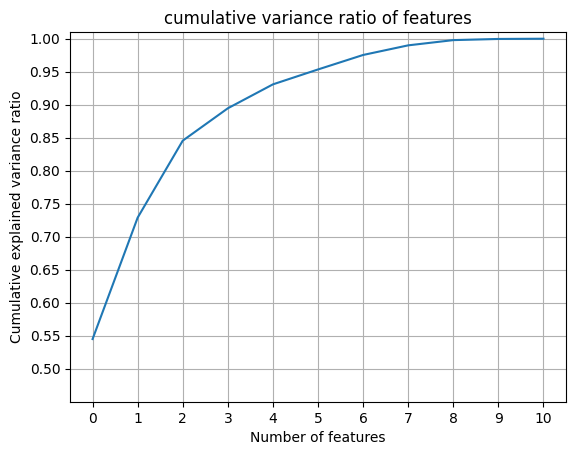

In [95]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
plt.title("cumulative variance ratio of features")
plt.xlabel("Number of features")
plt.ylabel("Cumulative explained variance ratio")
plt.xticks(range(0,11))
plt.yticks(np.arange(0.50, 1.05, 0.05))
plt.ylim(0.45, 1.01)
plt.show()

FIGURE 3: The cumulative sum of the explained variance ratio showing we would need to keep 9 principle components (feature 0 to feature 8) in order to retain >99.5% of the information

This means we can fit >99.5% of the information in our dataset into 9 components

In [96]:
#fit PCA to normalised features with dimensionality reduced by 2
pca = decompose.PCA(n_components=9)
pca.fit(fire_weather_included_frame)
fire_weather_included_frame = pd.DataFrame(pca.transform(fire_weather_included_frame))

We have now reduced the dimensionality of our FWI inclusive dataset from 11 features to 9 using principle component analysis with a negligible amount of data loss

##3.Building our models<a name="section3"></a>

In order to prevent our models from being trained on the same data that they would be tested on we will split our two feature frames into train test split datasets, our models will be trained on 80% of the dataset and tested on the remaining 20%. Even though we are testing 4 models we will make two test datasets so that we can test the ability for each type of model to make predictions on the same samples.

In [97]:
#split data into test and train(FWI included)
x_train_FWI, x_test_FWI, y_train_FWI, y_test_FWI = skmodel.train_test_split(fire_weather_included_frame, label_frame, test_size = 0.2, train_size = 0.8)
#split data into test and train (FWI excluded)
x_train_NFWI, x_test_NFWI, y_train_NFWI, y_test_NFWI = skmodel.train_test_split(fire_weather_excluded_frame, label_frame, test_size = 0.2, train_size = 0.8)

###<ins>3.1 Decision tree</ins><a name="subsection3.1"></a>

The first model we will attempt to try is a decision tree, we will apply a tree to both data frames (one that includes the FWI and one that excldues the FWI). We will protect against overcomplexity of either tree by setting a maximum tree depth equal to the dimensions of our most complex dataset

In [98]:
tree = sktree.DecisionTreeClassifier(max_depth=9)

####<ins>3.1.1 FWI included</ins><a name="subsection3.1.1"></a>

[]

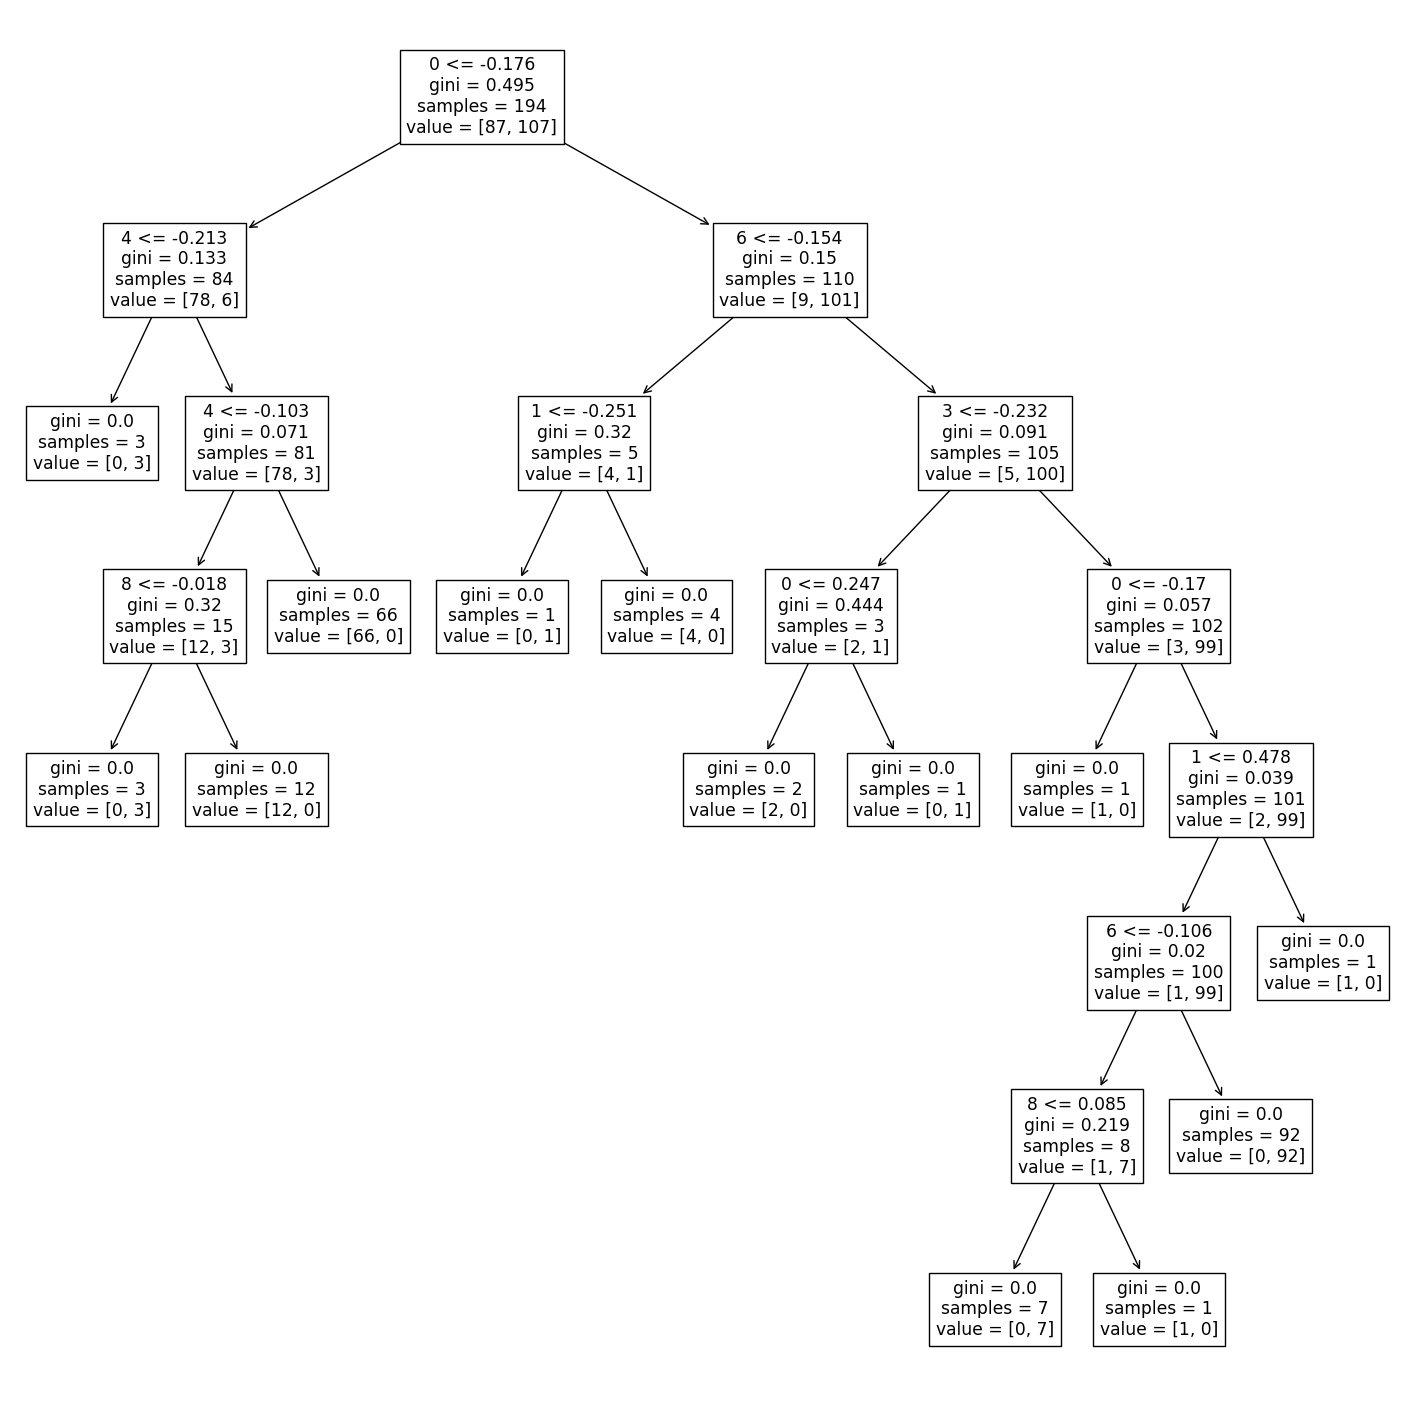

In [99]:
#visualise tree
fitted_estimator_FWI = tree.fit(X=x_train_FWI, y=y_train_FWI)
plt.figure(figsize=(18,18))
sktree.plot_tree(fitted_estimator_FWI, feature_names=fire_weather_included_frame.columns)
plt.plot()

FIGURE 4: The tree generated from our first dataset included FWI features, the names of the features in the tree won't be readable as we have fitted our model using principle component analysis making each column no longer solely representative of the features presented in the original data frame.

In [100]:
#accuracy score for next section
tree_model_accuracy_FWI = skmetrics.accuracy_score(y_test_FWI, fitted_estimator_FWI.predict(x_test_FWI))

#store visualisation of a confusion matrix with for next section
predictions = fitted_estimator_FWI.predict(x_test_FWI)
cm_FWI = skmetrics.confusion_matrix(y_test_FWI, predictions, labels = fitted_estimator_FWI.classes_)

####<ins>3.1.2 FWI excluded</ins><a name="subsection3.1.2"></a>

[]

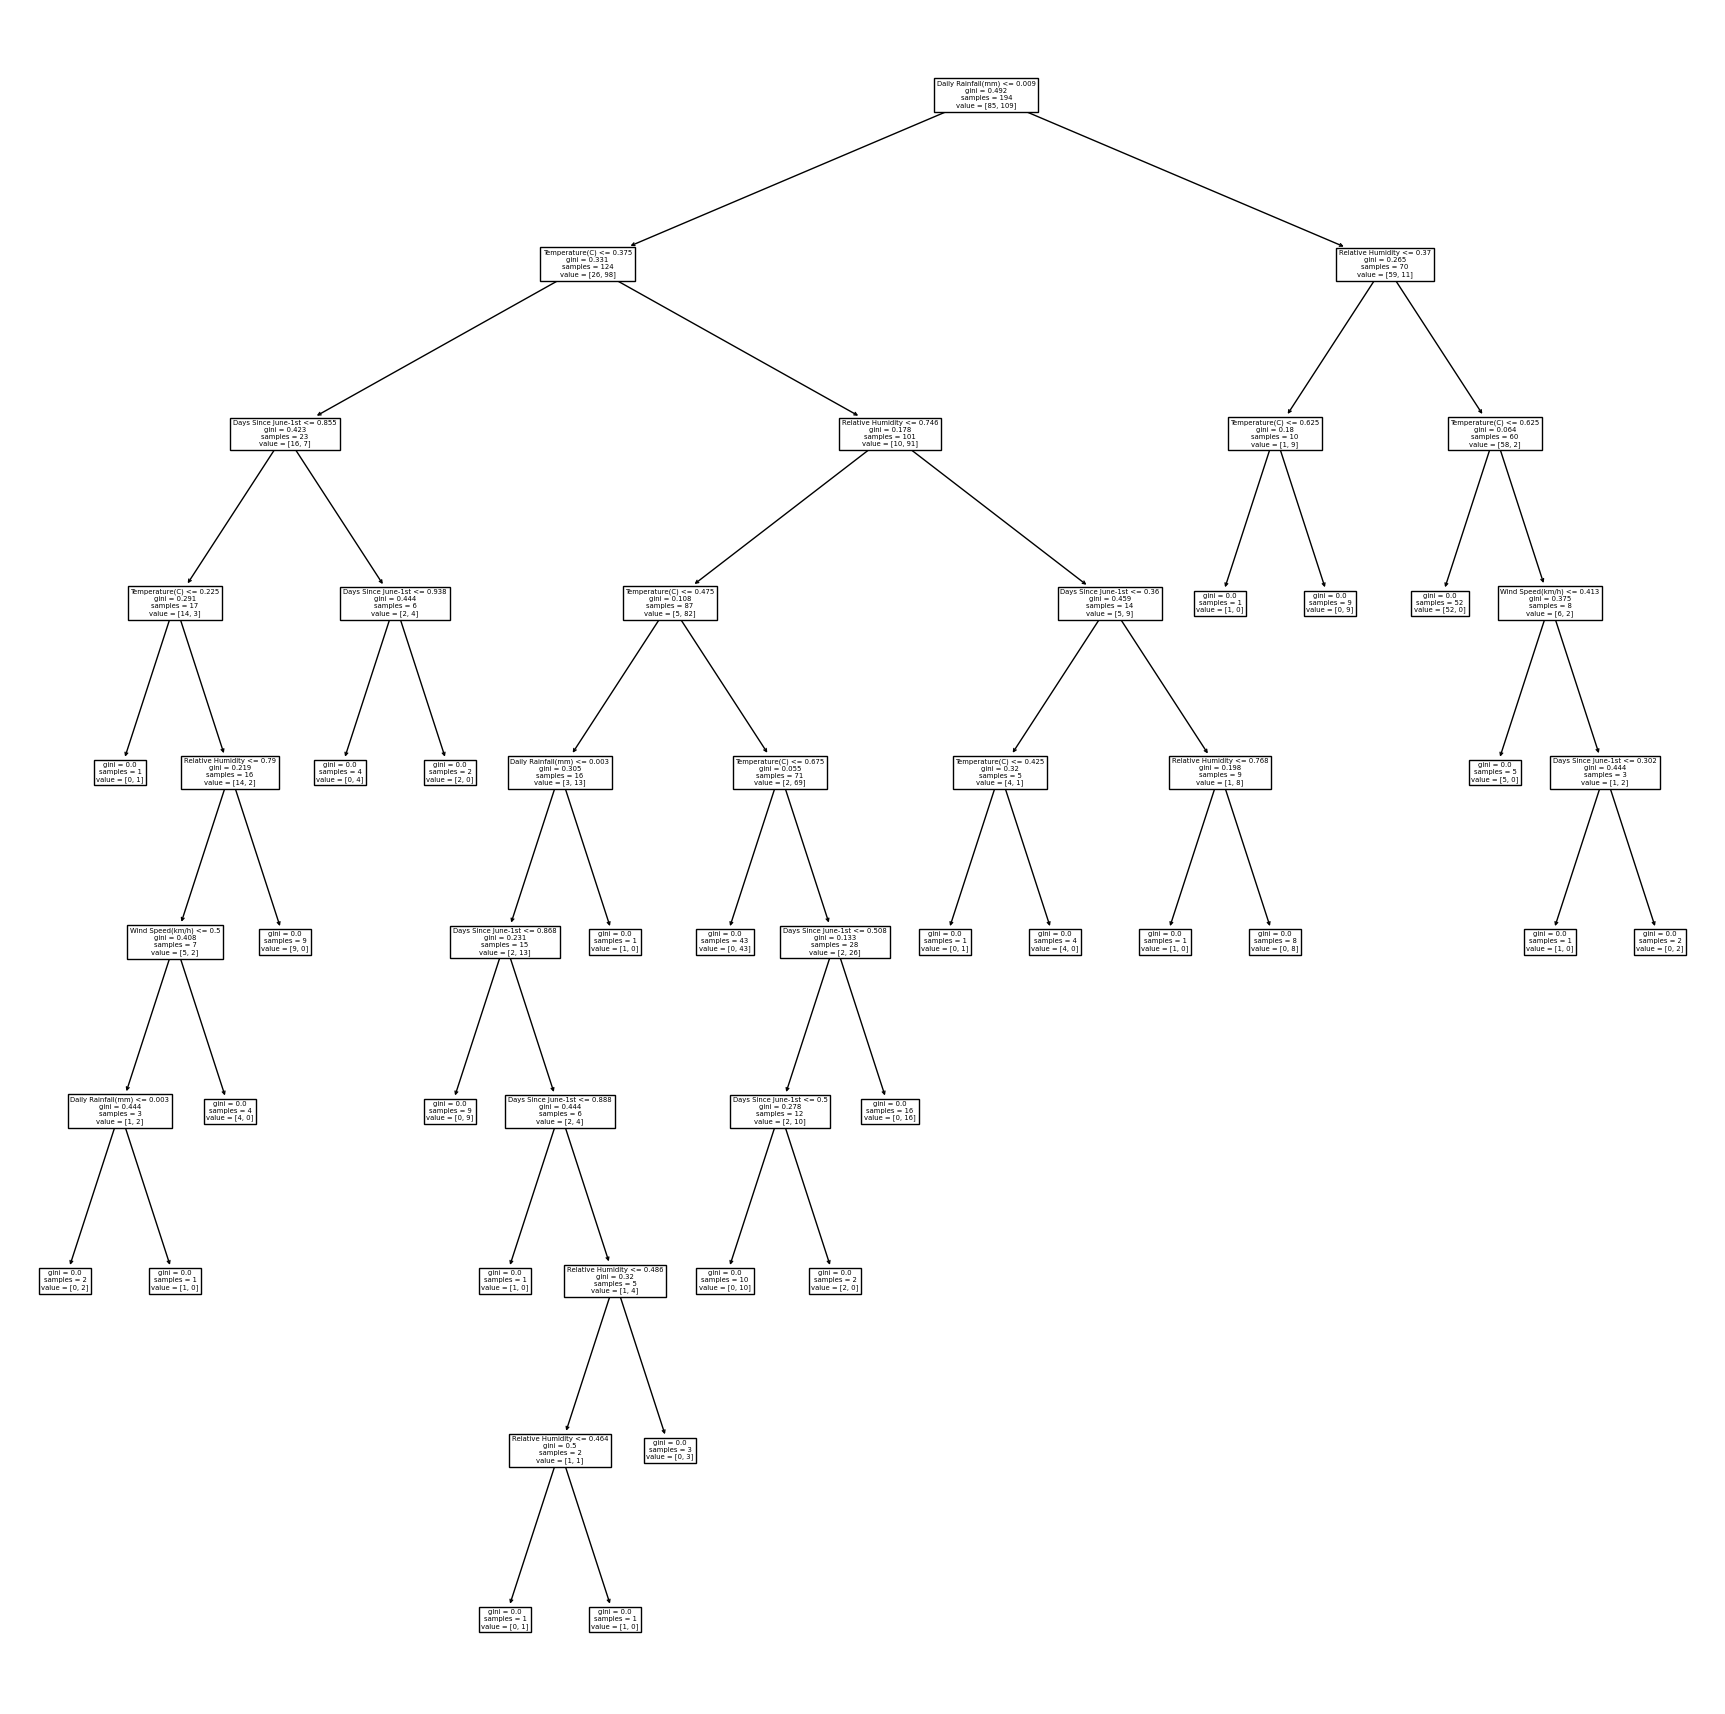

In [101]:
#visualise tree
fitted_estimator_NFWI = tree.fit(X=x_train_NFWI, y=y_train_NFWI)
plt.figure(figsize=(22,22))
sktree.plot_tree(fitted_estimator_NFWI, feature_names=fire_weather_excluded_frame.columns)
plt.plot()

FIGURE 5: The tree generated from our dataset excluding FWI features, as this feature frame has not undergone principle component analysis we can garner more insight from the visualisation of our decision tree.

In [102]:
#accuracy score for next section
tree_model_accuracy_NFWI = skmetrics.accuracy_score(y_test_NFWI, fitted_estimator_NFWI.predict(x_test_NFWI))

#store visualisation of a confusion matrix and accuracy score for next section
predictions = fitted_estimator_NFWI.predict(x_test_NFWI)
cm_NFWI = skmetrics.confusion_matrix(y_test_NFWI, predictions, labels = fitted_estimator_NFWI.classes_)

###<ins>3.2 Neural network</ins><a name="subsection3.2"></a>

Our second model will be a neural network trained both on the fire weather index data set and the dataset excluding the fire weather index. We will give each neural network an equal number of iterations that are enough for convergence of both networks to make their predictions on the test data. Given that our classification problem has two exact values of 0 and 1, the sigmoid transformation works as the perfect activation function to determine a threshold for our neural networks predictions.

In [103]:
#FWI included
FWI_neural_network_model = network.MLPClassifier(activation='logistic', max_iter=1200).fit(x_train_FWI, y_train_FWI)
FWI_neural_network_model.predict(x_test_FWI)
FWI_neural_accuracy = FWI_neural_network_model.score(x_test_FWI, y_test_FWI)

#store visualisation of a confusion matrix and accuracy score for next section
predictions = FWI_neural_network_model.predict(x_test_FWI)
cm_neural_FWI = skmetrics.confusion_matrix(y_test_FWI, predictions)

In [104]:
#FWI excluded
NFWI_neural_network_model = network.MLPClassifier(activation='logistic', max_iter=1200).fit(x_train_NFWI, y_train_NFWI)
NFWI_neural_network_model.predict(x_test_NFWI)
NFWI_neural_accuracy = NFWI_neural_network_model.score(x_test_NFWI, y_test_NFWI)

#store visualisation of a confusion matrix and accuracy score for next section
predictions = NFWI_neural_network_model.predict(x_test_NFWI)
cm_neural_NFWI = skmetrics.confusion_matrix(y_test_NFWI, predictions)

##4. Discussion of results <a name="section4"></a>

###<ins>4.1 Confusion matrices</ins><a name="subsection4.1"></a>

Now that we have built our models we can determine how accurately our models predicted the occurences of wildfires in the test data

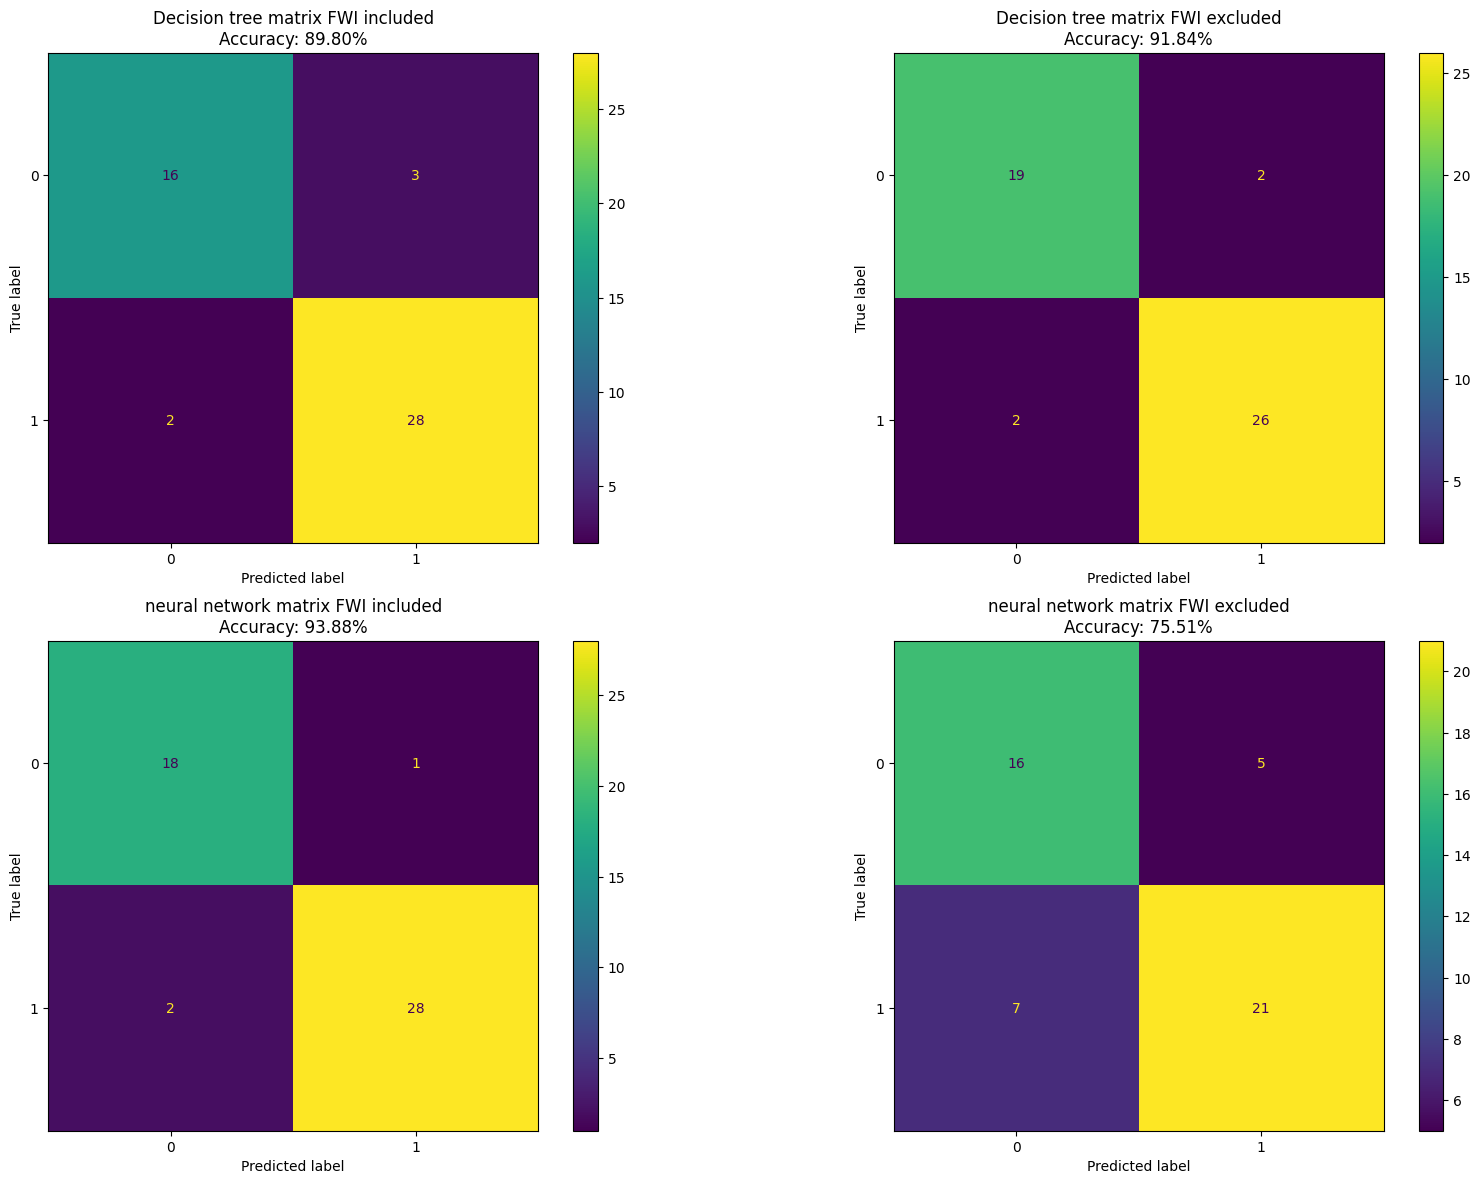

In [105]:
#plotting two matrices next to each other
fig, axs = plt.subplots(2, 2, figsize=(20,14))

#plot first confusion matrix(tree)
disp1 = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm_FWI, display_labels=fitted_estimator_FWI.classes_)
disp1.plot(ax=axs[0,0])
axs[0,0].set_title(f'Decision tree matrix FWI included\nAccuracy: {tree_model_accuracy_FWI * 100:.2f}%')

#plot second confusion matrix(tree)
disp2 = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm_NFWI, display_labels=fitted_estimator_NFWI.classes_)
disp2.plot(ax=axs[0,1])
axs[0,1].set_title(f'Decision tree matrix FWI excluded\nAccuracy: {tree_model_accuracy_NFWI * 100:.2f}%')

#plot third confusion matrix(neural)
disp3 = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm_neural_FWI)
disp3.plot(ax=axs[1,0])
axs[1,0].set_title(f'neural network matrix FWI included\nAccuracy: {FWI_neural_accuracy * 100:.2f}%')

#plot third confusion matrix(neural)
disp4 = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm_neural_NFWI)
disp4.plot(ax=axs[1,1])
axs[1,1].set_title(f'neural network matrix FWI excluded\nAccuracy: {NFWI_neural_accuracy * 100:.2f}%')
plt.show()

FIGURE 6: Four confusion matrices representing the results of our models predictions paired with the true value of each sample. The top left representing our decision tree model trained on data including FWI. The top right representing our decision tree model trained on data excluding FWI. The bottom left representing our neural network trained on data including FWI and the bottom right representing our neural network trained on data excluding FWI.

###<ins>4.2 Use the Fire Weather Index or exclude it?</ins><a name="subsection4.2"></a>

Due to the principle component analysis done on the FWI data we cannot determine the logic our models took to come to their predictions on the test data, we can however compare the depth and number of branches of our first decision tree and our second one. The First decision tree which included our FWI data came to it's conclusion after a maximum depth of 7 branches, our second tree continued until in some cases it reached the depth limit of 9 branches before it was forced to terminate and come to a conclusion.

Training our models on data including the FWI features significantly improved both the neural network and decision tree classifiers predictions. Bias drastically reduced with its inclusion before the added variance from the extra features caused an overfitting of our model.

It was very evident when we excluded FWI data, our decision tree vastly increased in its complexity and depth with worse predictive outcomes. Our neural network which had FWI data excluded struggled massively to reach a reliable classification threshold, occasionally setting it so low that it predicted a wildfire 100% of the time. This further reinforces the fact that the FWI contributes significantly to our capabilities to predict a forest fire in the region and should therefore be included in future models generated for the region.

###<ins>4.3 Neural network or decision tree?</ins><a name="subsection4.3"></a>

For every run of our four models a similar pattern played out unique to all four of them.



1.   Our decision tree which included data on the Fire Weather Index reliably had an accuracy rating of between 85-100% and was weakly biased towards generating false negatives
2.   Our decision tree which excluded data on the Fire Weather Index reliably had an accuracy rating of between 70-95% and was weakly biased towards generating false negatives
3. Our neural network which included data on the Fire Weather Index reliably had an accuracy rating of 90-100% and was weakly biased towards generating false positives
4. Our neural network which excluded data on the Fire Weather Index unreliably ranged from an accuracy of 50-85% and was very strongly biased towards generating false positives (occasionally it would always predict a wildfire suggesting an extremely low classification threshold for a wildfire)


From these insights we can determine a decision tree more reliably came to a correct prediction when FWI data was excluded. However when a neural network is given FWI data it has a higher probability of generating a model that is more accurate than a decision tree. Therefore if enough information is given to a neural network it becomes the superior model. If FWI cannot be performed however a decision tree becomes the better model to use.

##5. Conclusion<a name="section5"></a>

###<ins>5.1 Limitations</ins><a name="subsection5.1"></a>

The most evident issue for the generation of a reliable model is the size of our dataset. Only 243 samples had to be used to train and test our models, a relatively low number for the number of classes we had to work with in our dataset. Furthermore all of these samples were collected over the course of one summer in 2012 instead of over multiple years. The climatic conditions of the mediterranean since then have shifted and we are expected to see a more dramatic shift in conditions as time goes on making any model we generate from this data increasingly unreliable[4].

Another big issue which can very cleary be seen from section 2.6 and the visualised logic of our second decision tree in section 3.1.2 is just how much the feature "Days Since June-1st" factored into our model. This suggests that the conditions that contribute to wildfire as summer progresses are not fully captured in the data collected and represented by the other features. Furthermore the "Days Since June-1st" feature is acting as a better representation of the climatic and environmental conditions that are clearly a part of its significance than the data we have collected to represent those features ourselves. This evident by the relatively high accuracy of predictions on the test data despite our overreliance on this feature.

In order to truly determine the benefits of the FWI in the mediterranean we would need to collect up to date samples across multiple areas. The limited range of our data collection increases the likelyhood that our model is unrepresentative of the entire climatic region. As discussed in section 1 during the introduction the fire weather index was developed on the assumption of pine fuel types, which does not translate to the biodiversity present in algeria or the mediterranean region in general[5].

###<ins>5.2 Our reccomendation</ins><a name="subsection5.2"></a>

Our insights have determined that when enough information is present to feed into our models, a neural network generates better returns on that increased dimensionality and sample size. More up to date samples in greater quantity must be taken over multiple regions in the mediterranean which factor in the currently predicted changes the climate will undergo as time goes on. Data collection in these regions should be continous in nature so as to consistently train and update the model with modern information so that it is not simply representative of wildfire occurence in a single year.

Further exploration of additional features may also better capture the complexity of wildfire occurence in the region. Therefore we also reccomend a study which investigates a more comprehensive set of features for the mediterranean climate. The fire weather index clearly provides an improvement on our ability to predict the occurence of wildfire in the mediterranean. Therefore this investigation should conclude in the creation a modified version of the fire weather index intended for the climate as laid out in the 2018 study in greece discussed during the introduction

## 6. References<a name="section6"></a>



1.   C. E. van Wagner. 1987. Development and structure of the Canadian Forest Fire Weather Index System. Forestry Technical Report, No. 35. Chalk River, ON: Canadian Forest Service, Petawawa National Forestry Institute, 37 pages.
2. Van Wagner, C. E. 1974. Structure of the Canadian forest fire weather index. Environment Canada, Forestry Service, Ottawa, ON, Canada, 1333.
3. Varela, V., Sfetsos, A., Vlachogiannis, D., and Gounaris, N. 2018. Fire Weather Index (FWI) classification for fire danger assessment applied in Greece. Tethys 15, 31-40.
4. Boudiaf, B., Dabanli, I., Boutaghane, H., and Şen, Z. 2020. Temperature and precipitation risk assessment under climate change effect in northeast Algeria. Earth Systems and Environment 4, 1-14.
5. Guerine, L., Hadjadj, K., Mouissa, H., Benamara, N., and Bendouina, N. 2022. Study of plant diversity in the rangelands of Stipa tenacissima L.: case of Sfissifa and El Biodh region (southwest Algeria). Current Trends in Natural Sciences 11, 21, 176-193.
